![](https://7612750.fs1.hubspotusercontent-na1.net/hubfs/7612750/logo%20Senpai_2022%20(1)-1.png)
# Proyecto final - Bootcamp Data Science

---

## Herramientas utilizadas

*   pandas
*   NumPy
*   matplotlib
*   plotly
*   h5py
*   pickle
*   XGBoost
*   prophet
*   TensorFlow
*   scikit-learn
*   Keras
*   Neptune

---

# Preámbulo

Esta notebook tiene el propósito de seleccionar el modelo de regresión con series temporales más adecuado, que realice un pronóstico de la ganancia de la empresa C.O.M.E.S.A en el mes de agosto de 2023.

## Datos

Los datos a usar son los archivos csv obtenidos de la ejecución de la notebook "datos_a_usar.ipynb".

 Dichos archivos son llamados de la forma ***viajes_stm_0x2023_comesa.csv*** (donde x se cambia por el mes en cuestión).

# Funciones y librerías

En el siguiente apartado se definen las funciones y se realizan las importaciones de las librerías aplicadas al desarrollo del proyecto.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import h5py
import pickle
import neptune
import xgboost as xgb
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from neptune.integrations.tensorflow_keras import NeptuneCallback
from neptune.exceptions import NeptuneModelKeyAlreadyExistsError
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

C:\Users\flopa\AppData\Local\Temp\ipykernel_3668\566823142.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\flopa\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def borrar_nulos(df):
  """Borra las filas con valores faltantes de un dataframe.

  Args:
        param1: df (pandas.core.frame.DataFrame)

  Returns:
        output1: df (pandas.core.frame.DataFrame)
  """
  df = df.dropna()
  return df

In [3]:
def validacion_no_nulos(lista_dfs):
    """Valida que ningún dataframe de una lista de dataframes quede con valores nulos.
        Devuelve True cuando se cumple la condición.

    Args:
        param1: lista_dfs (list)

    Returns:
        output1: bool
    """
    hay_nulos = False
    for df in lista_dfs:
        hay_nulos = df.isna().any().any()
    return hay_nulos == False

In [4]:
"""
Las tarifas se obtuvieron de:
https://montevideo.gub.uy/areas-tematicas/sistema-de-transporte-metropolitano/tarifas-del-transporte-colectivo-urbano

La forma de aplicar esta función se obtuvo de:
https://medium.com/@michalwesleymnach/the-complete-guide-to-create-columns-based-on-multiple-conditions-in-pandas-dataframes-eedf2c0392a6

"""

def agregarImporte(con_tarjeta, tipo_viaje, cantidad_pasajeros):
    """Devuelve el importe total de un viaje teniendo en cuenta si el viaje es
        con tarjeta, qué tipo de viaje es y la cantidad de pasajeros.

    Args:
        param1: con_tarjeta (int64)
        param2: tipo_viaje (float64)
        param3: cantidad_pasajeros (int64)

    Returns:
        output1: float64
    """
    #tipo_viaje 12 y 14 no existen

    importe = 0

    if tipo_viaje == 1:
      #Viaje común
      importe = 52
    elif tipo_viaje == 2:
      #Viaje zona
      if con_tarjeta == 1:
        importe = 20
      else:
        importe = 27
    elif tipo_viaje == 3:
      #Viaje céntrico
      if con_tarjeta == 1:
        importe = 29
      else:
        importe = 39
    elif tipo_viaje == 4:
      #Viaje diferencial
      if con_tarjeta == 1:
        importe = 62
      else:
        importe = 78
    elif tipo_viaje == 5:
      #Viaje una hora
      if con_tarjeta == 1:
        importe = 42
      else:
        importe = 52
    elif tipo_viaje == 6:
      #Viaje dos horas
      if con_tarjeta == 1:
        importe = 62
      else:
        importe = 78
    elif tipo_viaje == 7:
      #Viaje estudiante categoría A
        importe = 23
    elif tipo_viaje == 8:
      #Viaje estudiante categoría B
        importe = 32.2
    elif tipo_viaje == 9:
      #Viaje estudiante gratuito
        importe = 0
    elif tipo_viaje == 10:
      #Viaje jubilado o pensionista categoría A
      if con_tarjeta == 1:
        importe = 11
      else:
        importe = 14
    elif tipo_viaje == 11:
      #Viaje jubilado o pensionista categoría B
      if con_tarjeta == 1:
        importe = 19
      else:
        importe = 22
    elif tipo_viaje == 13:
      #Viaje combinación metropolitana
      importe = 66
    elif tipo_viaje == 15:
      #Viaje gratuito
      importe = 0
    elif tipo_viaje == 16:
      #Boleto ABC
      importe = 33
    elif tipo_viaje == 17:
      #Viaje prepago nominado
      importe = 38.7
    elif tipo_viaje == 18:
      #Viaje para usuario/a frecuente
      importe = 39
    elif tipo_viaje == 19:
      #Trab. Med. y larga dist.
      importe = 0

    return importe*cantidad_pasajeros

In [5]:
def acondicionarDf(df):
  """Realiza ajustes para acondicionar el dataset.

  Args:
      param1: df (pandas.core.frame.DataFrame)

  Returns:
      output1: dfaux (pandas.core.frame.DataFrame)
  """

  dfaux = df.copy()

  # La columna dsc_linea venía con tipos de datos mezclados, se convierte a str
  dfaux['dsc_linea'] = dfaux['dsc_linea'].astype(str)

  # Crea la columna importe y le asigna los valores correspondientes
  func = np.vectorize(agregarImporte)
  dfaux["importe"] = func(dfaux["con_tarjeta"], dfaux["tipo_viaje"], dfaux["cantidad_pasajeros"])

  # Convierte fecha_evento a datetime
  dfaux['fecha_evento'] = pd.to_datetime(dfaux['fecha_evento'])

  # Le quita los minutos y los segundos a la hora
  dfaux['fecha_evento'] = pd.to_datetime(dfaux['fecha_evento'].dt.strftime('%Y-%m-%d %H:00:00'))

  # Agrupa por fecha y sumariza los importes
  dfaux = dfaux.groupby(dfaux.fecha_evento)[['importe']].sum()

  # El group by genera multiindices, usando reset_index pasan a ser columnas
  dfaux = dfaux.reset_index()

  return dfaux

In [6]:
def lista_dfs_preparados(lista_dfs):
  """Recibe una lista de dataframes y
      devuelve una lista contienendo los dataframes preparados.

  Args:
      param1: lista_dfs (list)

  Returns:
      output1: lista_dfs_preparados (list)
  """

  lista_dfs_preparados = []
  for df in lista_dfs:
    df_i = acondicionarDf(df)
    lista_dfs_preparados.append(df_i)

  return lista_dfs_preparados

In [7]:
"""
Esta función fue tomada de:
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

"""

def split_sequence(sequence, n_steps):
	"""Divide una secuencia flatten en muchas muestras cada una de las cuales
			tiene un número especificado (n_steps) de datestamps.
			Devuelve el array 2D obtenido como se especifica y un array 1D
			que tiene un solo datestamp.

  Args:
      param1: sequence (pandas.core.series.Series)
			param2: n_steps (int)

  Returns:
      output1: numpy.ndarray
			output2: numpy.ndarray
  """

	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [8]:
def grafica_residuos_neptune(name_model,y_true, y_pred):
  """Grafica los residuos en función del tiempo.

  Args:
      param1: name_model (str)
			param2: y_true (numpy.ndarray)
      param3: y_pred (numpy.ndarray)

  """
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  run["evaluation/{}/mse".format(name_model)] = mse
  run["evaluation/{}/mae".format(name_model)] = mae
  run["evaluation/{}/r2".format(name_model)] = r2

  residuals = y_true - y_pred
  matriz_residuals = np.vstack((np.arange(len(residuals)), residuals))
  matriz_residuals = np.transpose(matriz_residuals)
  residuals_df = pd.DataFrame(matriz_residuals, columns=['Tiempo','Residuos'])

  fig = px.line(residuals_df, x="Tiempo", y="Residuos", title='Modelo: {}'.format(name_model) + '      '
  "MSE: %.3f MAE: %.3f R2: %.3f" % (mse,mae,r2))
  fig.show()

In [9]:
def validacion_cruzada(model,X,y,tscv):
  """Realiza validación cruzada en una serie temporal para el modelo (model)
      con el conjunto de datos de train (X) y los targets (y)

  Args:
      param1: model
			param2: X (numpy.ndarray)
      param3: y (numpy.ndarray)
      param4: tscv (sklearn.model_selection._split.TimeSeriesSplit)

  Returns:
      output1: numpy.ndarray
			output2: numpy.ndarray
  """

  y_pred_val = np.array([])
  y_val = np.array([])

  # Realizar la validación cruzada manualmente y obtener predicciones
  for train_index, val_index in tscv.split(X):

    X_training, X_validation = X[train_index], X[val_index]
    y_training, y_validation = y[train_index], y[val_index]

    y_val = np.concatenate([y_val,y_validation])

    model.fit(X_training, y_training)

    y_pred_fold = model.predict(X_validation)
    y_pred_val = np.concatenate([y_pred_val, y_pred_fold])

  return y_val,y_pred_val

In [10]:
"""
La función fue extraída de la documentación de TensorFlow tf.data.Dataset

"""

def prepare_data(data, lookback, batch_size):
  """Convierte los datos a un tf.data.Dataset y los prepara para la LSTM.

  Args:
      param1: data (pandas.core.series.Series)
			param2: lookback (int)
      param3: batch_size (int)

  Returns:
      output1: dataset (tf.data.Dataset)
  """
  dataset = tf.data.Dataset.from_tensor_slices(data.values)
  dataset = dataset.window(lookback + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(lookback + 1))
  dataset = dataset.map(lambda window: (window[:-1][..., np.newaxis], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# Carga de datos

In [11]:
# completar con la ruta a los csv obtenidos de la notebook "datos_a_usar.ipynb"
# si no se hace ninguna modificación luego de ejecutar la notebook "datos_a_usar.ipynb", el base_path debería ser '' 

base_path = ''

In [12]:
df_2 = pd.read_csv(base_path + 'viajes_stm_022023_comesa.csv')
df_3 = pd.read_csv(base_path + 'viajes_stm_032023_comesa.csv')
df_4 = pd.read_csv(base_path + 'viajes_stm_042023_comesa.csv')
df_5 = pd.read_csv(base_path + 'viajes_stm_052023_comesa.csv')
df_6 = pd.read_csv(base_path + 'viajes_stm_062023_comesa.csv')
df_7 = pd.read_csv(base_path + 'viajes_stm_072023_comesa.csv')
df_8 = pd.read_csv(base_path + 'viajes_stm_082023_comesa.csv')

C:\Users\flopa\AppData\Local\Temp\ipykernel_3668\1193484194.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_3 = pd.read_csv(base_path + 'viajes_stm_032023_comesa.csv')
C:\Users\flopa\AppData\Local\Temp\ipykernel_3668\1193484194.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_4 = pd.read_csv(base_path + 'viajes_stm_042023_comesa.csv')
C:\Users\flopa\AppData\Local\Temp\ipykernel_3668\1193484194.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_5 = pd.read_csv(base_path + 'viajes_stm_052023_comesa.csv')
C:\Users\flopa\AppData\Local\Temp\ipykernel_3668\1193484194.py:5: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_6 = pd.read_csv(base_path + 'viajes_stm_062023_comesa.csv')


# Limpieza de datos

## Análisis exploratorio de los datos

In [13]:
print('Febrero:', '\n', df_2.isna().sum())
print('\n')
print('Marzo:', '\n', df_3.isna().sum())
print('\n')
print('Abril:', '\n', df_4.isna().sum())
print('\n')
print('Mayo:', '\n', df_5.isna().sum())
print('\n')
print('Junio:', '\n', df_6.isna().sum())
print('\n')
print('Julio:', '\n', df_7.isna().sum())
print('\n')
print('Agosto:', '\n',  df_8.isna().sum())

Febrero: 
 Unnamed: 0                        0
id_viaje                          0
con_tarjeta                       0
fecha_evento                      0
tipo_viaje                        0
descripcion_tipo_viaje            0
grupo_usuario                     0
descripcion_grupo_usuario         0
grupo_usuario_especifico          0
descripcion_grupo_usuario_espe    0
ordinal_de_tramo                  0
cantidad_pasajeros                0
codigo_parada_origen              0
cod_empresa                       0
descrip_empresa                   0
linea_codigo                      0
dsc_linea                         0
sevar_codigo                      0
dtype: int64


Marzo: 
 Unnamed: 0                        0
id_viaje                          0
con_tarjeta                       0
fecha_evento                      0
tipo_viaje                        5
descripcion_tipo_viaje            5
grupo_usuario                     0
descripcion_grupo_usuario         0
grupo_usuario_especifico     

## Limpieza

>Nota: Se decidió eliminar los nulos en todos los dataframes porque como mucho habían 10 en un dataframe de más de 2 millones de filas.

In [14]:
df_3 = borrar_nulos(df_3)
df_6 = borrar_nulos(df_6)
df_7 = borrar_nulos(df_7)
df_8 = borrar_nulos(df_8)

In [15]:
lista_dfs = [df_2,df_3,df_4,df_5,df_6,df_7,df_8]

In [16]:
# Si devuelve True estamos en la condición de que no hay ningún valor faltante en ningún dataframe
validacion_no_nulos(lista_dfs)

True

# Creación de datasets a partir de lista de dataframes

In [17]:
lista_dfs_preparados = lista_dfs_preparados(lista_dfs[:-1])
df_train = pd.concat(lista_dfs_preparados, ignore_index=True)

df_train = df_train[['fecha_evento', 'importe']]

In [18]:
df_test = acondicionarDf(df_8)

df_test = df_test[['fecha_evento', 'importe']]

## Creación de las matrices de regresión

In [19]:
X_train, y_train = split_sequence(df_train['importe'], 24)

X_train.shape, y_train.shape

((4293, 24), (4293,))

In [20]:
X_test, y_test = split_sequence(df_test['importe'], 24)

X_test.shape, y_test.shape

((720, 24), (720,))

# Análisis y Visualizaciones

In [21]:
fig = px.line(df_train, x="fecha_evento", y="importe", title='Ganancia en los meses desde febrero hasta julio del 2023')
fig.show()

>**Observaciones:** Se puede observar en el gráfico que la serie temporal de estudio tiene un comportamiento bastante periódico en los meses desde febrero 2023 hasta julio 2023. Tiene componentes estacionales, feriados o vacaciones, que se pueden ver pero sin contar esos casos se logra apreciar la periodicidad de la serie temporal.
Esto indica que los modelos de forecasting podrían funcionar bien debido a que pueden capturar y aprender ese patrón periódico para hacer predicciones futuras.

# Modelos predictivos

In [22]:
# Instanciar clase de TimeSeriesSplit para hacer validación cruzada
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

## Random Forest

### Estandarización / Normalización

In [23]:
normalizer = preprocessing.MinMaxScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

y_train_norm = normalizer.fit_transform(y_train.reshape(-1, 1))
y_train_norm = y_train_norm.reshape((len(y_train_norm)))

y_test_norm = normalizer.transform(y_test.reshape(-1, 1))
y_test_norm = y_test_norm.reshape((len(y_test_norm)))

### Conexión con Neptune

In [24]:
run = neptune.init_run(
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==",
)

parameters = {
    "n_estimators": 1000
}

run["model_RF/parameters"] = parameters

try:
    model_RF_Neptune = neptune.init_model(
    name="Random Forest",
    key="MOD",
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==", # your credentials
    )

except NeptuneModelKeyAlreadyExistsError:
    # If it already exists, we don't have to do anything.
    pass

model_RF_Neptune = neptune.init_model_version(
      model="PROY-MOD",
      project="Senpai/ProyectoFinal",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzgzMDUzYS01NTQ1LTQ2M2EtODMyMi0xOTJkY2ZmZGZjZGEifQ==", # your credentials
      )

c:\Users\flopa\anaconda3\envs\gpu\lib\site-packages\neptune\common\warnings.py:71: NeptuneWarning:

The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/



https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-397
https://app.neptune.ai/Senpai/ProyectoFinal/m/PROY-MOD/v/PROY-MOD-67


### Modelo

In [25]:
model_RF = RandomForestRegressor(n_estimators = parameters["n_estimators"], random_state=42)

### Validación cruzada

In [26]:
y_val, y_pred_val = validacion_cruzada(model_RF,X_train_norm,y_train_norm,tscv)

In [27]:
grafica_residuos_neptune('Random Forest', y_val, y_pred_val)

>Observaciones: En el gráfico de validación de Random Forest (validación cruzada) se aprecia que el modelo mejora sus predicciones a medida que pasa el tiempo. Esta tendencia se observa en que los residuos disminuyen a medida que avanza la línea temporal. Debido a que el modelo ha sido entrenado cada vez con más datos.

### Guardar modelo y subirlo a Neptune

In [28]:
with open(base_path + 'best_model_RF.pkl', 'wb') as f:
    pickle.dump(model_RF, f)

In [29]:
model_RF_Neptune["model_RF"].upload(base_path + "best_model_RF.pkl")

In [30]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-397/metadata


## XG-Boost

### Estandarización / Normalización

In [31]:
normalizer = preprocessing.MinMaxScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

y_train_norm = normalizer.fit_transform(y_train.reshape(-1, 1))
y_train_norm = y_train_norm.reshape((len(y_train_norm)))

y_test_norm = normalizer.transform(y_test.reshape(-1, 1))
y_test_norm = y_test_norm.reshape((len(y_test_norm)))

### Conexión con Neptune

In [32]:
run = neptune.init_run(
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==",
)

parameters = {
    "n_estimators": 1000
}

run["model_XGB/parameters"] = parameters

try:
    model_XGB_Neptune = neptune.init_model(
    name="XGBoost",
    key="MOD",
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==", # your credentials
    )

except NeptuneModelKeyAlreadyExistsError:
    # If it already exists, we don't have to do anything.
    pass

model_XGB_Neptune = neptune.init_model_version(
      model="PROY-MOD",
      project="Senpai/ProyectoFinal",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzgzMDUzYS01NTQ1LTQ2M2EtODMyMi0xOTJkY2ZmZGZjZGEifQ==", # your credentials
      )

https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-399
https://app.neptune.ai/Senpai/ProyectoFinal/m/PROY-MOD/v/PROY-MOD-68


### Modelo

In [33]:
model_XGB = xgb.XGBRegressor(n_estimators=parameters['n_estimators'], random_state=42)

### Validación cruzada

In [34]:
y_val, y_pred_val = validacion_cruzada(model_XGB,X_train_norm,y_train_norm,tscv)

In [35]:
y_val.shape, y_pred_val.shape

((3575,), (3575,))

In [36]:
grafica_residuos_neptune('XGBoost', y_val, y_pred_val)

>Observaciones: Así como en Random Forest, en el gráfico de validación de XGBoost (validación cruzada) se aprecia que el modelo mejora sus predicciones a medida que pasa el tiempo. Esta tendencia se observa en que los residuos disminuyen a medida que avanza la línea temporal. Debido a que el modelo ha sido entrenado cada vez con más datos.

### Guardar modelo y subirlo a Neptune

In [37]:
with open(base_path + 'best_model_XGB.pkl', 'wb') as f:
    pickle.dump(model_XGB, f)

In [38]:
model_XGB_Neptune["model_XGB"].upload(base_path + "best_model_XGB.pkl")

In [39]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-399/metadata


## LSTM

### Estandarización / Normalización

In [40]:
df_lstm_train = df_train.copy()
df_lstm_test = df_test.copy()

df_training = df_lstm_train.iloc[:3000]
df_val = df_lstm_train.iloc[3000:]
df_val = df_val.reset_index(drop=True)

scaler = preprocessing.StandardScaler()

df_training['importe'] = scaler.fit_transform(df_training[['importe']])
df_val['importe'] = scaler.transform(df_val[['importe']])
df_lstm_test['importe'] = scaler.transform(df_lstm_test[['importe']])

C:\Users\flopa\AppData\Local\Temp\ipykernel_3668\3153802282.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
# Preparar datos de entrenamiento, validación y testeo
lookback = 2  # Define valor de lookback (ventana hacia atrás para predicciones)
batch_size = 12  # Define valor de batch_size
horizon = 1 # Cantidad de pasos a predecir

train_data = prepare_data(df_training['importe'], lookback, batch_size)
val_data = prepare_data(df_val['importe'], lookback, batch_size)
test_data = prepare_data(df_lstm_test['importe'], lookback, batch_size)

### Conexión con Neptune

In [42]:
run = neptune.init_run(
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==",
)

parameters = {
    "dense_units": 4,
    "batch_size": 12,
    "n_epochs": 40,
}

run["model_LSTM/parameters"] = parameters

try:
    model_LSTM_Neptune = neptune.init_model(
    name="LSTM",
    key="MOD",
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==", # your credentials
    )

except NeptuneModelKeyAlreadyExistsError:
    # If it already exists, we don't have to do anything.
    pass

model_LSTM_Neptune = neptune.init_model_version(
      model="PROY-MOD",
      project="Senpai/ProyectoFinal",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzgzMDUzYS01NTQ1LTQ2M2EtODMyMi0xOTJkY2ZmZGZjZGEifQ==", # your credentials
      )

https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-401
https://app.neptune.ai/Senpai/ProyectoFinal/m/PROY-MOD/v/PROY-MOD-69


### Modelo

In [43]:
model = Sequential()
model.add(LSTM(128, input_shape=(lookback, 1), return_sequences = True))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(32,))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 2, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________


In [44]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='best_model_LSTM.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='max')

neptune_callback = NeptuneCallback(run=run, base_namespace='metrics')

callbacks = [early_stopping,checkpoint,neptune_callback]

### Validación

In [45]:
history = model.fit(train_data,
                    epochs=parameters['n_epochs'],
                    validation_data=val_data,
                    callbacks=callbacks)

Epoch 1/40


c:\Users\flopa\anaconda3\envs\gpu\lib\site-packages\neptune\common\warnings.py:71: NeptuneUnsupportedType:

You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type



250/250 [==============================] - 12s 21ms/step - loss: 0.3147 - val_loss: 0.1025
Epoch 2/40
250/250 [==============================] - 3s 13ms/step - loss: 0.0756 - val_loss: 0.0643
Epoch 3/40
250/250 [==============================] - 3s 13ms/step - loss: 0.0612 - val_loss: 0.0609
Epoch 4/40
250/250 [==============================] - 2s 10ms/step - loss: 0.0532 - val_loss: 0.0575
Epoch 5/40
250/250 [==============================] - 3s 12ms/step - loss: 0.0473 - val_loss: 0.0543
Epoch 6/40
250/250 [==============================] - 3s 10ms/step - loss: 0.0445 - val_loss: 0.0517
Epoch 7/40
250/250 [==============================] - 3s 11ms/step - loss: 0.0432 - val_loss: 0.0499
Epoch 8/40
250/250 [==============================] - 2s 10ms/step - loss: 0.0424 - val_loss: 0.0488
Epoch 9/40
250/250 [==============================] - 3s 10ms/step - loss: 0.0419 - val_loss: 0.0482
Epoch 10/40
250/250 [==============================] - 2s 10ms/step - loss: 0.0415 - val_loss: 0.0478

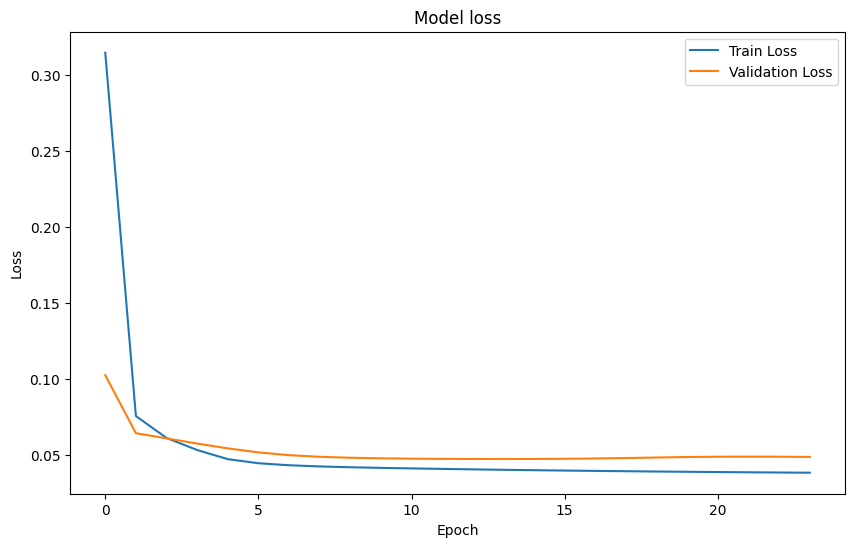

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

>Observaciones: De la gráfica de entrenamiento del modelo se visualiza que los valores de pérdida descienden rápidamente luego de pocas épocas. El modelo capturó las tendencias y los patrones de los datos sin tender al sobreajuste. Lo que indica un ajuste adecuado de los hiperparámetros.

In [47]:
y_val = np.array(df_val[['importe']][2:])
y_val = y_val.reshape(len(y_val))

y_pred_val = model.predict(val_data)
y_pred_val = y_pred_val.reshape(len(y_pred_val))

110/110 [==============================] - 2s 5ms/step


In [48]:
grafica_residuos_neptune('LSTM', y_val, y_pred_val)

>Observaciones: En el gráfico de validación de LSTM se ve que el modelo mantiene valores bajos residuales, sin embargo no se nota una disminución de los residuos a lo largo del entrenamiento, como sí se veía en los modelos de Random Forest y XGBoost. Una posible  explicación de este hecho es que no se hizo validación cruzada.

### Guardar modelo y subirlo a Neptune

In [49]:
model.save(base_path + 'best_model_LSTM.keras')

In [50]:
model_LSTM_Neptune["model_LSTM"].upload(base_path + "best_model_LSTM.keras")

In [51]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
All 6 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-401/metadata


## Prophet

### Escalado de datos

In [52]:
# Escalado logarítmico
df_prophet_train = df_train.copy()
df_prophet_test = df_test.copy()

df_prophet_train['importe'] = np.log1p(df_prophet_train['importe'])
df_prophet_test['importe'] = np.log1p(df_prophet_test['importe'])

In [53]:
train = df_prophet_train.iloc[:3000]
val = df_prophet_train.iloc[3000:]

df_prophet_train = train
df_prophet_train.columns = ['ds', 'y']

df_prophet_val = val
df_prophet_val.columns = ['ds', 'y']

df_prophet_test.columns = ['ds', 'y']

### Conexión con Neptune

In [54]:
run = neptune.init_run(
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==",
)

parameters = {
    "periods": 1317,
    "freq": "H"
}

run["model_Prophet/parameters"] = parameters

try:
    model_Prophet_Neptune = neptune.init_model(
    name="Prophet",
    key="MOD",
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==", # your credentials
    )

except NeptuneModelKeyAlreadyExistsError:
    # If it already exists, we don't have to do anything.
    pass

model_Prophet_Neptune = neptune.init_model_version(
      model="PROY-MOD",
      project="Senpai/ProyectoFinal",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzgzMDUzYS01NTQ1LTQ2M2EtODMyMi0xOTJkY2ZmZGZjZGEifQ==", # your credentials
      )


https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-403
https://app.neptune.ai/Senpai/ProyectoFinal/m/PROY-MOD/v/PROY-MOD-70


### Modelo

In [64]:
m = Prophet()

m.fit(df_prophet_train)

00:32:05 - cmdstanpy - INFO - Chain [1] start processing
00:32:06 - cmdstanpy - INFO - Chain [1] done processing


### Validación

In [65]:
future_val = m.make_future_dataframe(periods=parameters["periods"], freq=parameters["freq"])
future_val = future_val.tail(len(df_prophet_val))
future_val

c:\Users\flopa\anaconda3\envs\gpu\lib\site-packages\prophet\forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,ds
3000,2023-06-07 03:00:00
3001,2023-06-07 04:00:00
3002,2023-06-07 05:00:00
3003,2023-06-07 06:00:00
3004,2023-06-07 07:00:00
...,...
4312,2023-07-31 19:00:00
4313,2023-07-31 20:00:00
4314,2023-07-31 21:00:00
4315,2023-07-31 22:00:00


In [66]:
forecast_val = m.predict(future_val)
forecast_val[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2023-06-07 03:00:00,7.900351,7.283213,8.512551
1,2023-06-07 04:00:00,8.969433,8.384588,9.564946
2,2023-06-07 05:00:00,10.425718,9.828838,11.030543
3,2023-06-07 06:00:00,11.570354,10.948202,12.124978
4,2023-06-07 07:00:00,12.037163,11.436688,12.587051
...,...,...,...,...
1312,2023-07-31 19:00:00,11.858042,11.128311,12.561968
1313,2023-07-31 20:00:00,11.518437,10.739399,12.231691
1314,2023-07-31 21:00:00,11.320283,10.564906,12.045670
1315,2023-07-31 22:00:00,11.142737,10.421937,11.897606


In [67]:
y_val = df_prophet_val['y'].values
y_pred_val = forecast_val['yhat'].values

In [68]:
grafica_residuos_neptune('Prophet', y_val, y_pred_val)

>Observaciones: En el gráfico de validación de Prophet también se ve que el modelo mantiene valores bajos residuales y tampoco se nota una disminución de los residuos a lo largo del entrenamiento, como sí se veía en los modelos de Random Forest y XGBoost. Una posible  explicación de este hecho es que no se hizo validación cruzada. Además se puede apreciar como Prophet aprende los patrones en los datos.

In [69]:
plot_plotly(m, forecast_val)

>Observaciones: El gráfico muestra en negro los valores de entrenamiento y en azul las predicciones. Nuevamente se observa que Prophet aprende los patrones de los datos.

In [70]:
plot_components_plotly(m, forecast_val)

>Observaciones: El primer gráfico muestra las tendencias a largo plazo ignorando la estacionalidad. Los otros dos nos permiten visualizar patrones semanales y diarios. Estas gráficas son útiles para entender cómo el modelo está interpretando los datos y qué factores están influyendo en los predicciones.

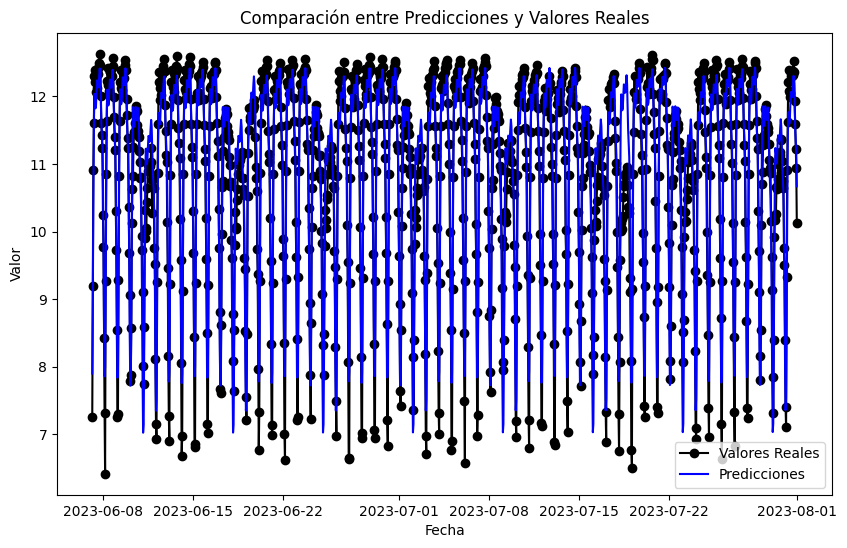

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(forecast_val['ds'], y_val, label='Valores Reales', marker='o', color='black')
plt.plot(forecast_val['ds'], y_pred_val, label='Predicciones', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.show()

>Observaciones: En la gráfica se superponen los valores reales con las predicciones, lo que nos permite ver que tan cercanos están entre sí.

### Guardar modelo y subirlo a Neptune

In [72]:
with open(base_path + 'best_model_Prophet.pkl', 'wb') as f:
    pickle.dump(m, f)

In [73]:
model_Prophet_Neptune["model_Prophet"].upload(base_path + 'best_model_Prophet.pkl')

In [74]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-403/metadata


# Análisis del motivo de la elección del modelo

Elegir el modelo más adecuado es un paso crucial para obtener buenos resultados. Según el análisis, de los cuatro modelos evaluados, Prophet sería la mejor elección, ya que está diseñado para trabajar con series temporales que tienen efectos estacionales fuertes y tendencias que son difíciles de modelar con otros métodos.

Razones por las cuales se elige Prophet:

* **Facilidad de uso**: Prophet es fácil de usar y requiere menos ajustes de hiperparámetros en comparación con otros modelos.

* **Manejo de estacionalidades**: Prophet maneja automáticamente múltiples estacionalidades (diaria, semanal, anual) y los efectos de días festivos.

* **Tendencias flexibles**: Prophet permite modelar cambios en las tendencias a lo largo del tiempo, lo cual fue útil dado que los datos utilizados tenían muchos puntos de cambio y una tendencia no lineal.

* **Predicciones y intervalos de confianza**: Prophet genera predicciones futuras con intervalos de confianza, lo que lleva a una mayor confiabilidad en los resultados obtenidos.

* **Eficiencia**: Prophet tiene el mejor balance entre tiempo de ejecución y resultados obtenidos. Además requiere poca capacidad de cómputo.

* **Binario liviano**: Comparado con los otros modelos, el tamaño del archivo generado es mucho menor.


# Performance modelo elegido

## Datos

In [75]:
data_train = df_train.copy()
data_train['importe'] = np.log1p(data_train['importe'])
data_train.columns = ['ds', 'y']

data_test = df_test.copy()
data_test['importe'] = np.log1p(data_test['importe'])
data_test.columns = ['ds', 'y']

## Entrenamiento del modelo

In [76]:
modelo_elegido = Prophet()

modelo_elegido.fit(data_train)

00:32:27 - cmdstanpy - INFO - Chain [1] start processing
00:32:27 - cmdstanpy - INFO - Chain [1] done processing


## Conexión con Neptune

In [77]:
run = neptune.init_run(
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==",
)

parameters = {
    "periods": 744,
    "freq": "H"
}

run["model_prod/parameters"] = parameters

try:
    model_prod_Neptune = neptune.init_model(
    name="Model Prod",
    key="MOD",
    project="Senpai/ProyectoFinal",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjJmNGI3Zi1hOTIxLTQyYmMtYjg2OC0wODUyNTVjOTRlMmUifQ==", # your credentials
    )

except NeptuneModelKeyAlreadyExistsError:
    # If it already exists, we don't have to do anything.
    pass

model_prod_Neptune = neptune.init_model_version(
      model="PROY-MOD",
      project="Senpai/ProyectoFinal",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYzgzMDUzYS01NTQ1LTQ2M2EtODMyMi0xOTJkY2ZmZGZjZGEifQ==", # your credentials
      )


https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-405
https://app.neptune.ai/Senpai/ProyectoFinal/m/PROY-MOD/v/PROY-MOD-71


## Test

In [78]:
future = modelo_elegido.make_future_dataframe(periods=parameters["periods"], freq=parameters["freq"])
future = future.tail(len(data_test))
future

c:\Users\flopa\anaconda3\envs\gpu\lib\site-packages\prophet\forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,ds
4317,2023-08-01 00:00:00
4318,2023-08-01 01:00:00
4319,2023-08-01 02:00:00
4320,2023-08-01 03:00:00
4321,2023-08-01 04:00:00
...,...
5056,2023-08-31 19:00:00
5057,2023-08-31 20:00:00
5058,2023-08-31 21:00:00
5059,2023-08-31 22:00:00


In [79]:
forecast = modelo_elegido.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2023-08-01 00:00:00,9.627835,9.056788,10.215394
1,2023-08-01 01:00:00,8.461745,7.899312,9.039043
2,2023-08-01 02:00:00,7.688723,7.110035,8.238742
3,2023-08-01 03:00:00,7.831813,7.313456,8.383430
4,2023-08-01 04:00:00,8.901138,8.367941,9.467460
...,...,...,...,...
739,2023-08-31 19:00:00,11.828789,11.251247,12.429519
740,2023-08-31 20:00:00,11.473954,10.918433,12.035217
741,2023-08-31 21:00:00,11.266937,10.655834,11.832194
742,2023-08-31 22:00:00,11.084168,10.497897,11.719685


In [80]:
y_test = data_test['y'].values
y_pred = forecast['yhat'].values

In [81]:
grafica_residuos_neptune('Prophet', y_test, y_pred)

In [82]:
plot_plotly(modelo_elegido, forecast)

In [83]:
plot_components_plotly(modelo_elegido, forecast)

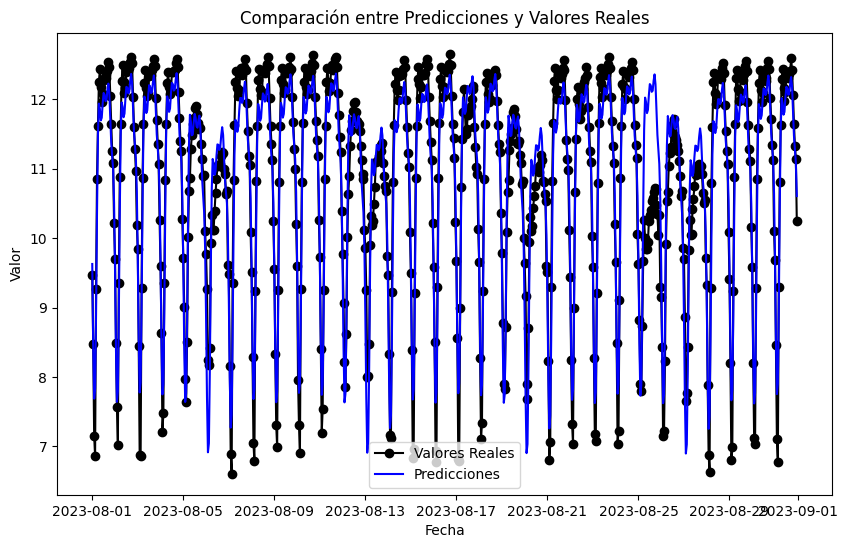

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], y_test, label='Valores Reales', marker='o', color='black')
plt.plot(forecast['ds'], y_pred, label='Predicciones', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación entre Predicciones y Valores Reales')
plt.legend()
plt.show()

## Guardar modelo y subirlo a Neptune

In [85]:
with open(base_path + 'best_model_prod.pkl', 'wb') as f:
    pickle.dump(modelo_elegido, f)

In [86]:
model_prod_Neptune["model_prod"].upload(base_path + 'best_model_prod.pkl')

In [87]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Senpai/ProyectoFinal/e/PROY-405/metadata


# Conclusión

En síntesis, la aplicación de modelos de series temporales puede proporcionar herramientas valiosas para el análisis de aspectos del transporte público. A través de un proceso riguroso, se eligió Prophet como el más adecuado, dada su capacidad de reconocer patrones, manejo de estacionalidad y otras bondades antes mencionadas. En comparación con los otros modelos evaluados, Prophet demostró ser superior en términos de equilibrio entre precisión, complejidad y tiempo de ejecución.

Con este proyecto se pudo reconocer la importancia de la comprensión del contexto del problema, el preprocesamiento de los datos y la selección de los modelos para resolver la problemática.

Cabe destacar que este proyecto tiene aplicación en casos reales, usando el modelo elegido se puede predecir la cantidad de meses hacia el futuro que se desee. Además, esto mismo se podría implementar para otras empresas que tengan datos similares lo que brinda gran flexibilidad a la hora de aplicar este modelo.